# Batch Processing!
#### A notebook to show some of the capilities available through the pCunch package

This is certainly not an exhaustive look at everything that the pCrunch module can do, but should hopefully provide some insight. 
...or, maybe I'm just procrastinating doing more useful work.

In [1]:
# Python Modules and instantiation
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import os
# %matplotlib widget
# ROSCO toolbox modules 
from ROSCO_toolbox import utilities as rosco_utilities
# WISDEM modules
from weis.aeroelasticse.Util import FileTools
# Batch Analysis tools
from pCrunch import Processing, Analysis
from pCrunch import pdTools

# Instantiate fast_IO
fast_io = rosco_utilities.FAST_IO()
fast_pl = rosco_utilities.FAST_Plots()

import importlib
Processing = importlib.reload(Processing)
Analysis = importlib.reload(Analysis)

## Define file paths and filenames
I'm loading a case matrix that is output when using wisdem.aeroelasticse.CaseGen_General to run a series of batch runs to initialize the output files here. 

Note that this isn't necessary, just my workflow in this notebook.

In [2]:
# point to some file paths
outfile_base = ['/Users/pbortolo/work/3_projects/3_BAR/loads/BAR02/loads_BAR02_200904/']
fname_case_matrix = [os.path.join(outfile_base[0],'case_matrix.yaml')]
case_names   = ['BAR02']

output_folder= '/Users/pbortolo/work/3_projects/3_BAR/loads/BAR02/Plots_200904_lowK11K22/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)


In [3]:
# Load case matrix into dataframe
cm = [''] * len(outfile_base)
for i in range(len(outfile_base)):
    case_matrix = FileTools.load_yaml(fname_case_matrix[i], package=1)
    cm[i] = pd.DataFrame(case_matrix)   


# pull wind speed values from InflowWind filenames
windspeeds, seed, IECtype, cmw = Processing.get_windspeeds(cm[0], return_df=True)
cmw.head()

,"(IEC, DLC)","(AeroDyn15, AFAeroMod)","(AeroDyn15, AIDrag)","(AeroDyn15, DBEMT_Mod)","(AeroDyn15, HubLoss)","(AeroDyn15, SkewMod)","(AeroDyn15, TIDrag)","(AeroDyn15, TanInd)","(AeroDyn15, TipLoss)","(AeroDyn15, TwrAero)",...,"(ServoDyn, PitManRat3)","(ServoDyn, TPitManS1)","(ServoDyn, TPitManS2)","(ServoDyn, TPitManS3)","(ServoDyn, TimGenOf)",Case_ID,Case_Name,"(InflowWind, WindSpeed)","(InflowWind, Seed)","(InflowWind, IECtype)"
0,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,0,BAR02_000,3.0,1,NTM
1,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,1,BAR02_001,3.0,2,NTM
2,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,2,BAR02_002,3.0,3,NTM
3,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,3,BAR02_003,3.0,4,NTM
4,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,4,BAR02_004,3.0,5,NTM


#### Comparison cases
I'm comparing two different controllers here, so I'm going to define two lists of output filenames, each corresponding to the output files from each controller

In [4]:
# Pare down case matrix for desired runs and load the outfiles
outfiles       = [''] * len(outfile_base)
outfiles_DLC11 = [''] * len(outfile_base)
import copy
cm_DLC11 = copy.copy(cm)
for i in range(len(outfile_base)):
    outnames   = []
    outnames_DLC11   = []
    drop_lines = []
    for j in range(len(cm[i])):
        outnames.append(outfile_base[i] + cm[i]['Case_Name'][j] + '.outb')
        if cm[i][('IEC', 'DLC')][j] == 1.1:
            outnames_DLC11.append(outfile_base[i] + cm[i]['Case_Name'][j] + '.outb')
        else:
            drop_lines.append(j)
    outfiles[i]       = outnames
    outfiles_DLC11[i] = outnames_DLC11
    drop_lines
    if drop_lines != []: 
        cm_DLC11[i] = cm_DLC11[i].drop(cm_DLC11[i].index[np.array(drop_lines)])

### outfiles
In the end, we just need a list of OpenFAST output files. Here, we have a structure that looks something like `[[], []]`. This could be extended any amount like `[[],[],...,[], []]`, or just be one list of strings `[]`.

## Now we can do some processing!

First, let's load the FAST_Processing class and initialize some parameters.


In [5]:
fp = Processing.FAST_Processing()
fp.OpenFAST_outfile_list = outfiles
fp.dataset_names = ['DLC1.1', 'DLC1.3']
fp.to = 120
fp.parallel_analysis = True
fp.save_LoadRanking = False
fp.save_SummaryStats = False
fp.verbose=True

# # Can defined specific variables for load ranking if desired
# fp.ranking_vars = [["RotSpeed"], 
#                     ["OoPDefl1", "OoPDefl2", "OoPDefl3"], 
#                     ['RootMxc1', 'RootMxc2', 'RootMxc3'],
#                     ['TwrBsFyt'],
#                     ] 

#### The fast way to compare things.
We could now collect all of the summary stats and load rankings using:
```
stats,load_rankings = fp.batch_processing()
```
In `fp.batch_processing()` most of the analysis is done for any structure of data. I'm going to step through things a bit more piecewise in this notebook, however.

NOTE: The goal in `batch_processing` is to have a "do anything" script. It is a work in progress, but getting there...

In [6]:
# stats,load_rankings = fp.batch_processing()

## Design Comparisons
We can use fp.design_comparison to compare multiple sets of runs (like we are in this case...). This will generate summary stats and load rankings, running in parrallel when it can and is told to. `fp.batch_processing()` functionally does the same thing if we give it an outfile matrix with equal size lists. We'll show the design comparison here to show a break down

In [8]:
stats, load_ranking = fp.design_comparison(outfiles)
stats_DLC11, load_ranking_DLC11 = fp.design_comparison(outfiles_DLC11)







Calculating load rankings.
Calculating load rankings.


#### Breaking it down further...

`fp.batch_processing()` calls `Analysis.Loads_Analysls.full_loads_analysis()` to load openfast data, generate stats, and calculate load rankings. Because we defined `fp.parallel_analysis=True` this process was parallelized. This helps for speed and memory reasons, because now every openfast run is not saved. `fp.batch_processing()` then takes all of the output data and parses it back together. 

Separately, we call call `Analysis.Loads_Analysls.full_loads_analysis()` with `return_FastData=True` and all of the fast data will be returned. Because we are comparing data though, we'll stick with the design comparison tools.


### We can look at our data a bit further with pandas dataframes
The data here is just for a few runs for simplicity. Usually you'd do this for a LOT more cases...

In [9]:
stats_df = pdTools.dict2df(stats, names=case_names[0])
stats_df.head()

B                                                            \
         B1N1Fxl                                                             
             abs    integrated            max          mean            min   
0  142834.327877  4.647284e+07  142834.327877  19846.511542  -91224.424351   
1  135836.859837  2.601539e+07  135836.859837  21682.102845  -84191.002597   
2  141733.622765 -1.536301e+07  141733.622765  23795.263397  -82628.149802   
3  132347.060258 -1.860408e+07  132347.060258  23116.825081  -98078.099848   
4  135268.768989 -2.392241e+07  135268.768989  17716.776220 -105868.353156   

                                                                          ...  \
                       B1N1Fyl                                            ...   
            std            abs    integrated            max         mean  ...   
0  56666.893002  286752.129569 -1.121099e+07  286752.129569  4064.732710  ...   
1  57782.194251  283278.714165 -1.695159e+08  283278.714165  3534.180567  ...   
2  57624.475322  282586.047754 -2.372877e+07  282586.047754  3126.676890  ...   
3  58976.206833  283598.015312  1.088501e+08  283598.015312  2510.686798  ...   
4  59908.098650  285535.199073  1.011297e+08  285535.199073  1139.643128  ...   

                                                                          \
  YawBrTDyt              YawPzn                                            
        min       std       abs integrated       max      mean       min   
0 -0.111145  0.043150  0.106279  -5.997726  0.094957  0.001066 -0.106279   
1 -0.183124  0.065311  0.073532  16.755068  0.073532  0.005174 -0.071378   
2 -0.121105  0.039679  0.136508   6.613661  0.115238  0.001683 -0.136508   
3 -0.180023  0.057353  0.112761 -42.032886  0.112761  0.005972 -0.086178   
4 -0.112290  0.045512  0.097462   0.101326  0.097462  0.013688 -0.095824   

                                                                           
                                                          meta             
        std                                           filename       name  
0  0.043062  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR02_000  
1  0.026196  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR02_001  
2  0.036202  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR02_002  
3  0.031823  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR02_003  
4  0.031625  /Users/pbortolo/work/3_projects/3_BAR/loads/BA...  BAR02_004  

[5 rows x 3146 columns]

### Load Ranking
Lets re-run the load ranking for the sake of example. We'll have to load the analysis tools, and then run the load ranking for the stats we just found

In [10]:
fa = Analysis.Loads_Analysis()
fa.t0 = 120
fa.verbose = False

Define the ranking variables and statiscits of interest. Note that `len(ranking_vars) == len(ranking_stats)`! We can pass this a list of stats (multiple runs), a dictionary with one run of stats, or a pandas dataframe with the requisite stats. If the inner list contains multiple OpenFAST channels, the load_rankings function will find the min/max/mean of the collection of the channels (e.g., max out of plane tip deflection of all three blades).  

We'll also output a dictionary and a pandas DataFrame from `fa.load_ranking()`

In [11]:
fa.ranking_vars = [['TipDxb1', 'TipDxb2', 'TipDxb3'],    ['TipDxb1', 'TipDxb2', 'TipDxb3'],
                   ['B1TipTDxr','B2TipTDxr','B3TipTDxr'],['B1TipTDxr','B2TipTDxr','B3TipTDxr'],
                   ['B1TipRDzr','B2TipRDzr','B3TipRDzr'],['B1TipRDzr','B2TipRDzr','B3TipRDzr'],
                   ['TipClrnc1','TipClrnc2','TipClrnc3'],['RootMyb1', 'RootMyb2', 'RootMyb3'],
                   ['RootMxb1', 'RootMxb2', 'RootMxb3'], ['TwrBsMxt'],
                   ['TwrBsMyt']]
fa.ranking_stats= ['max', 'min',
                   'max', 'min',
                   'max', 'min',
                   'min','abs',
                   'abs','abs',
                   'abs']
uom          = ['[m]', '[m]',
                '[m]', '[m]',
                '[m]', '[m]',
                '[m]','[kNm]',
                '[kNm]','[kNm]',
                '[kNm]'] * len(cm)
load_ranking, load_ranking_df = fa.load_ranking(stats_df, get_df=True)
load_ranking_df.head()

B                                                              \
   B1TipRDz                                       B1TipTDx                
        max max_case_idx       min min_case_idx        max max_case_idx   
0  0.309265          151 -0.707653          113  24.830297          113   
1  0.203996          173 -0.531469          112  23.529935          112   
2  0.200542          197 -0.326596           89  12.921363          126   
3  0.200542          196 -0.324054          109  12.844085          127   
4  0.199913          193 -0.316722           88  12.631817           79   

                                                ...                        \
                          RootMxb               ... TipClrnc                
         min min_case_idx     abs abs_case_idx  ...      min min_case_idx   
0 -11.645199          173     0.0          197  ...      0.0            0   
1 -11.222526          171     0.0           73  ...      0.0          126   
2 -10.754383          149     0.0           71  ...      0.0          127   
3 -10.559611          104     0.0           70  ...      0.0          128   
4 -10.531628          169     0.0           69  ...      0.0          129   

                                                                     \
  TipDxb                                      TwrBsMxt                
     max max_case_idx  min min_case_idx            abs abs_case_idx   
0    0.0          197  0.0            0  153278.933355          190   
1    0.0           73  0.0          126  150118.044166          186   
2    0.0           71  0.0          127  146128.233051          187   
3    0.0           70  0.0          128  145481.097687          197   
4    0.0           69  0.0          129  145481.097687          196   

                               
        TwrBsMyt               
             abs abs_case_idx  
0  225076.633760          113  
1  196914.240904          111  
2  191605.952558          105  
3  187326.529922          110  
4  181912.141539           85  

[5 rows x 22 columns]

This is organized for each iteration of `[ranking_vars, ranking_stats]`. The stats are ordered accordingly, and `(stat)_case_idx` refers to the case name index of each load. 

## Wind speed related analysis
We often want to make sense of some batch output data with data binned by windspeed. We can leverage the case-matrix from our output data to figure out the input wind speeds. Of course, `('InflowWind', 'Filename')` must exist in the case matrix. Lets load the wind speeds, save them, and append them to the case matrix as `('InflowWind', 'WindSpeed')`.

In [12]:
windspeed, seed, IECtype, cmw = Processing.get_windspeeds(cm[0], return_df=True)
cmw

,"(IEC, DLC)","(AeroDyn15, AFAeroMod)","(AeroDyn15, AIDrag)","(AeroDyn15, DBEMT_Mod)","(AeroDyn15, HubLoss)","(AeroDyn15, SkewMod)","(AeroDyn15, TIDrag)","(AeroDyn15, TanInd)","(AeroDyn15, TipLoss)","(AeroDyn15, TwrAero)",...,"(ServoDyn, PitManRat3)","(ServoDyn, TPitManS1)","(ServoDyn, TPitManS2)","(ServoDyn, TPitManS3)","(ServoDyn, TimGenOf)",Case_ID,Case_Name,"(InflowWind, WindSpeed)","(InflowWind, Seed)","(InflowWind, IECtype)"
0,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,0,BAR02_000,3.0,1,NTM
1,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,1,BAR02_001,3.0,2,NTM
2,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,2,BAR02_002,3.0,3,NTM
3,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,3,BAR02_003,3.0,4,NTM
4,1.1,2,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,4,BAR02_004,3.0,5,NTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,193,BAR02_193,30.0,4,NTM
194,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,194,BAR02_194,30.0,5,NTM
195,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,195,BAR02_195,30.0,5,NTM
196,6.3,1,True,1,True,2,True,True,True,True,...,2.0,9999.9,9999.9,9999.9,9999.9,196,BAR02_196,30.0,6,NTM


### AEP
Now that we know the wind speeds that we were operating at, we can find the AEP. We define the turbine class here, and the cumulative distribution or probability density function 
for the Weibull distribution per IEC 61400 is generated. We can then calculate the AEP. 

If we first want to verify the PDF, we initialize the `power_production` function, define the turbine class, and can plot a PDF (or CDF) for a given range of wind speeds:

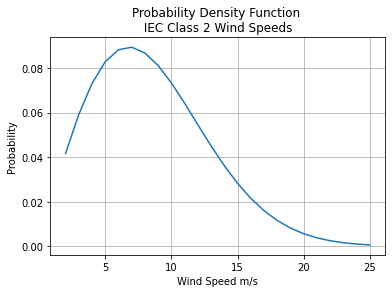

In [13]:
pp = Analysis.Power_Production()
pp.turbine_class = 2
Vrange = np.arange(2,26) # Range of wind speeds being considered
weib_prob = pp.prob_WindDist(Vrange,disttype='pdf')
plt.close('all')
plt.plot(Vrange, weib_prob)
plt.grid(True)
plt.xlabel("Wind Speed m/s")
plt.ylabel('Probability')
plt.title('Probability Density Function \n IEC Class 2 Wind Speeds ')
plt.show()


To get the AEP, we need to provide the wind speeds that the simulations were run for, and the corresponding average power results. Internally, in power_production.AEP, the mean power for a given average wind sped is multiplied times the wind speed's probability, then extrapolated to represent yearly production. 

Note: this might throw a python warning due to some poor pandas indexing practices - to be cleaned up eventually!

To get the AEP for each, the process is simple:

In [14]:
windspeeds_DLC11, seed, IECtype, cmw = Processing.get_windspeeds(cm_DLC11[0], return_df=True)
AEP = pp.AEP(stats_DLC11, windspeeds_DLC11)
print('AEP = {}'.format(AEP))

AEP = [25593631.81726431]


/Users/pbortolo/work/2_openfast/pCrunch/pCrunch/Analysis.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pwr_array['windspeeds'] = ws


##### About the wind speed warning:
Here, we get a warning about the input windspeed array. This is because we passed the complete array output from Processing.get_windspeeds to the AEP function. The input windspeeds to power_production.AEP must satisfy either of the following two conditions:
- each wind speed value corresponds to each each statistic value, so `len(windspeeds) = len(stats_df)`
- each wind speed value corresponds to each run in the case matrix, so `len(windspeeds) = len(cm)`

If the second of these conditions is satisfied, it is assumed that each dataset has the same wind speeds corresponding to each run. So, in this case, the wind speeds corresponding to DLC_1.1 and DLC_1.3 should be the same. 

## Plotting
Finally, we can make some plots. There are a few tools we have at our disposal here. First, we can look at more plots that show our design performance as a function of wind speed. Notably, we can pass the stats dictionary or dataframe to these statistics-related scripts.

Currently, `an_plts.stat_curve()` can plot a "statistics curve" for of two types, a bar or a line graph. 

A bar graph is useful to compare design cases easily:

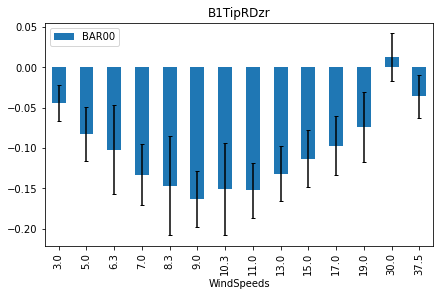

In [15]:
plt.close()
an_plts = Analysis.wsPlotting()
an_plts.stat_curve(windspeeds, stats, 'B1TipRDzr', 'bar', names=['BAR00'])
plt.show()

A line graph can be useful to show turbulent wind curves. Here we show the means with a first level of errorbars corresponding to standard deviations, and a second level showing minimums and maximums.

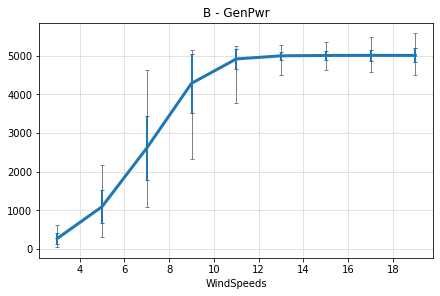

In [16]:
an_plts.stat_curve(windspeeds_DLC11, stats_DLC11, 'GenPwr', 'line', stat_idx=0, names=case_names[0])
plt.show()

### Load Ranking (soon)
We can plot the load rankings... 
... pulling this into `Analysis.py` is in progress.

First, we define how we will classify our comparisons. Most commonly this would be `('IEC','DLC')`, but I'm comparing controllers here. The `classifier_type` functionally refers to the channel of the case matrix to separate the data by, and the `classifier_names` are simply labels for the classifiers. 

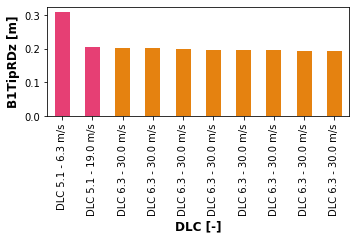

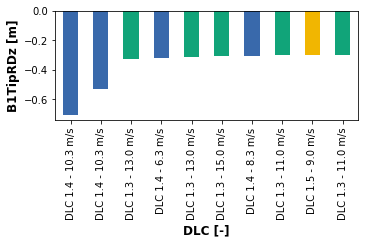

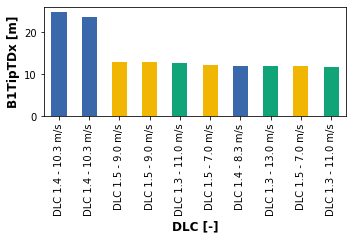

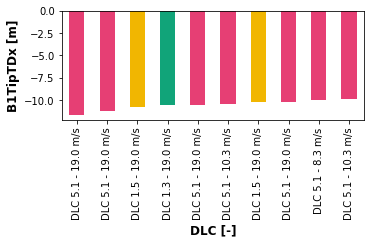

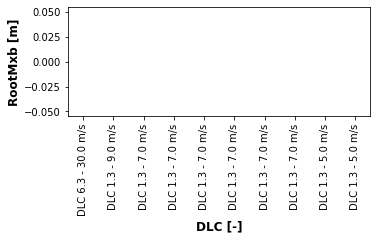

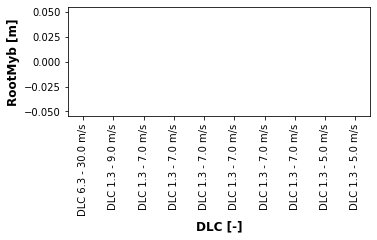

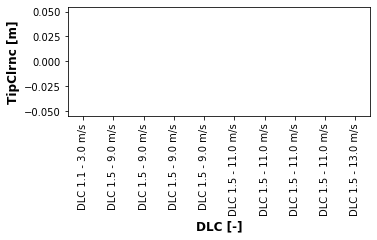

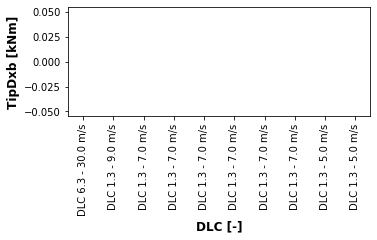

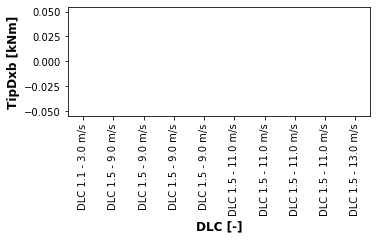

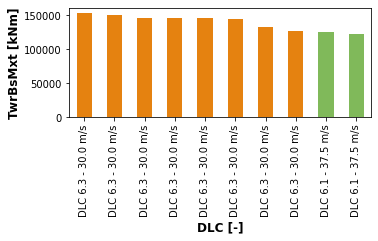

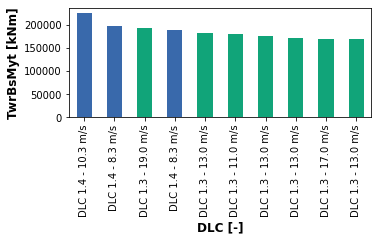

In [17]:
# Plot bar charts
flag_DLC_name = True
n_ranking     = 10
extension     = '.pdf'
from palettable.cartocolors.qualitative import Bold_7

Clr = Bold_7

for k in range(int(0.5 * len(load_ranking_df.columns))):
    ch_i = int(k*2)
    colors = np.zeros((n_ranking, 3))
    case   = load_ranking_df.columns[ch_i][0]
    channel= load_ranking_df.columns[ch_i][1]
    stat   = load_ranking_df.columns[ch_i][2]
    labels = n_ranking * ['']
    for i in range(n_ranking):
        DLC_class = str(cm[0][('IEC', 'DLC')][load_ranking_df[case][channel][stat + '_case_idx'][i]])
        if DLC_class == '1.1':
            colors[i,:] = np.array(Clr.colors[0])/256.
        elif DLC_class == '1.3':
            colors[i,:] = np.array(Clr.colors[1])/256.
        elif DLC_class == '1.4':
            colors[i,:] = np.array(Clr.colors[2])/256.
        elif DLC_class == '1.5':
            colors[i,:] = np.array(Clr.colors[3])/256.
        elif DLC_class == '5.1':
            colors[i,:] = np.array(Clr.colors[4])/256.
        elif DLC_class == '6.1':
            colors[i,:] = np.array(Clr.colors[5])/256.
        elif DLC_class == '6.3':
            colors[i,:] = np.array(Clr.colors[6])/256.
        else:
            colors[i,:] = np.array(Clr.colors[7])/256.

        start = cm[0][('InflowWind', 'Filename')][load_ranking_df[case][channel][stat + '_case_idx'][i]].find('_U') + 2
        end   = cm[0][('InflowWind', 'Filename')][load_ranking_df[case][channel][stat + '_case_idx'][i]].find('.') + 2
        WS = cm[0][('InflowWind', 'Filename')][load_ranking_df[case][channel][stat + '_case_idx'][i]][start:end]

        labels[i] = 'DLC ' + DLC_class +' - ' + WS + ' m/s'
        labels_index = load_ranking_df[case][channel][stat + '_case_idx'][0:n_ranking]


    fig, ax = plt.subplots()
    #ax.set_ylim([-20., 0.])
    #cl = -15.9 # 6.2
    #plt.plot([-2. , 12.],[cl, cl], '--', color = np.array(Clr.colors[2])/256.)
    load_ranking_df[case][channel][stat][0:n_ranking].plot.bar(color=colors)
    #plt.title('BAR01 - Vout 19 m/s', fontsize=10+2, fontweight='bold')
    plt.xlabel('DLC [-]', fontsize=10+2, fontweight='bold')
    plt.ylabel(channel + ' ' + uom[k], fontsize=10+2, fontweight='bold')
    if flag_DLC_name:
        plt.xticks(np.arange(n_ranking), labels=labels)
    else:
        plt.xticks(np.arange(n_ranking), labels=labels_index)
    plt.subplots_adjust(bottom = 0.5, left = 0.2)
    fig.savefig(output_folder + 'ranking_' + case + '_' + channel + '_' + stat + extension)
    
plt.show()

In [18]:
load_ranking_df

B                                                              \
     B1TipRDz                                       B1TipTDx                
          max max_case_idx       min min_case_idx        max max_case_idx   
0    0.309265          151 -0.707653          113  24.830297          113   
1    0.203996          173 -0.531469          112  23.529935          112   
2    0.200542          197 -0.326596           89  12.921363          126   
3    0.200542          196 -0.324054          109  12.844085          127   
4    0.199913          193 -0.316722           88  12.631817           79   
..        ...          ...       ...          ...        ...          ...   
193 -0.066889           20 -0.094426            1   4.252007            1   
194 -0.072779          132 -0.091545            5   4.120021          143   
195 -0.078809           23 -0.088863            3   3.927534          144   
196 -0.082802           18 -0.087511          116   3.086380          148   
197 -0.083688          128 -0.073285          115   2.861009          147   

                                                  ...                        \
                            RootMxb               ... TipClrnc                
           min min_case_idx     abs abs_case_idx  ...      min min_case_idx   
0   -11.645199          173     0.0          197  ...      0.0            0   
1   -11.222526          171     0.0           73  ...      0.0          126   
2   -10.754383          149     0.0           71  ...      0.0          127   
3   -10.559611          104     0.0           70  ...      0.0          128   
4   -10.531628          169     0.0           69  ...      0.0          129   
..         ...          ...     ...          ...  ...      ...          ...   
193   1.783468           13     0.0          129  ...      0.0           69   
194   2.135751          128     0.0          128  ...      0.0           70   
195   3.061372           17     0.0          127  ...      0.0           71   
196   3.245577           14     0.0          126  ...      0.0           73   
197   3.327847           12     0.0            0  ...      0.0          197   

                                                                       \
    TipDxb                                      TwrBsMxt                
       max max_case_idx  min min_case_idx            abs abs_case_idx   
0      0.0          197  0.0            0  153278.933355          190   
1      0.0           73  0.0          126  150118.044166          186   
2      0.0           71  0.0          127  146128.233051          187   
3      0.0           70  0.0          128  145481.097687          197   
4      0.0           69  0.0          129  145481.097687          196   
..     ...          ...  ...          ...            ...          ...   
193    0.0          129  0.0           69    8622.164598          114   
194    0.0          128  0.0           70    8192.548650          125   
195    0.0          127  0.0           71    7899.735558          117   
196    0.0          126  0.0           73    5755.639642          120   
197    0.0            0  0.0          197    5008.225261          116   

                                 
          TwrBsMyt               
               abs abs_case_idx  
0    225076.633760          113  
1    196914.240904          111  
2    191605.952558          105  
3    187326.529922          110  
4    181912.141539           85  
..             ...          ...  
193   64942.974232            4  
194   54025.900577          114  
195   44812.973775          115  
196   40495.573273          117  
197   39727.630750          116  

[198 rows x 22 columns]

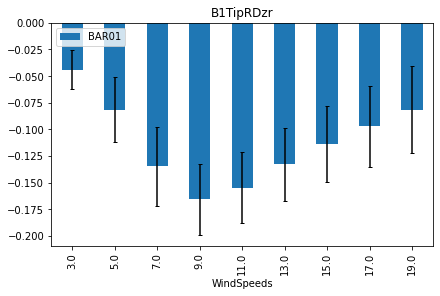

In [19]:
# Plot torsional deformations
plt.close()
an_plts = Analysis.wsPlotting()
an_plts.stat_curve(windspeeds_DLC11, stats_DLC11, 'B1TipRDzr', 'bar', names=['BAR01'])
plt.show()

### Time domain plotting
We can also look at our data from the time domain results. 

We can compare any number of channels using the ROSCO toolbox plotting tools. First we'll load two cases to plot together, then plot the time histories.

In [27]:
#  Load some time domain cases 
filenames = [outfiles[0][40]] # select the 70th run from each dataset
fast_data = fast_io.load_FAST_out(filenames, tmin=0)


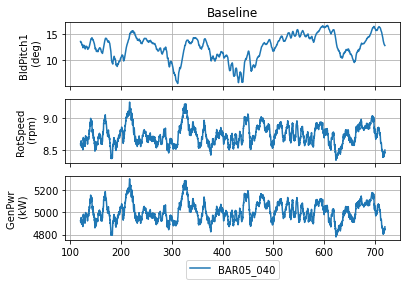

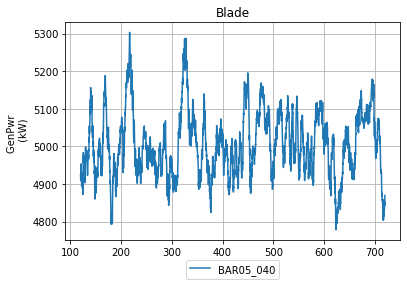

In [28]:
# Define the plots we want to make (can be as many or as few channels and plots as you would like...)
cases = {'Baseline': ['BldPitch1', 'RotSpeed','GenPwr'],
        'Blade' : ['GenPwr']}

# plot
fast_pl.plot_fast_out(cases, fast_data)
plt.show()

### Spectral Analysis

We can additionally do some frequency domain analysis. Here, `spec_cases` is defined by `(channel, run)` where the run index corresponds to the desired plotting index in the loaded fast data.



[WARN] dt from tmax-tmin different from dt from t2-t1
[WARN] dt from tmax-tmin different from dt from t2-t1


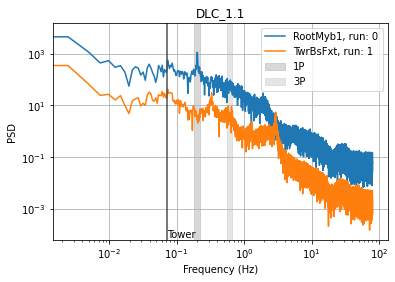

In [19]:
spec_cases = [('RootMyb1', 0), ('TwrBsFxt', 1)]
twrfreq = .0716
twrfreq_label = ['Tower']
fig, ax = fast_pl.plot_spectral(fast_data, spec_cases, 
                                show_RtSpeed=True, RtSpeed_idx=[0],
                                add_freqs=[twrfreq], add_freq_labels=twrfreq_label,
                                averaging='Welch')
ax.set_title('DLC_1.1')
plt.show()

### Other fun plots

Finally, we can plot the data distribution of any channels from our fast output data

In [127]:
channels = ['GenPwr']
caseid = [0,1]
an_plts.distribution(fast_data, channels, caseid, names=['ROSCO', 'Legacy'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## In conclusion...
If you made it this far, thanks for reading... 

There are a number of smaller subfunctionalities that are also available within these tools shows above. Perhaps most importantly, everything is fairly modularar - the hope being that these can provide some high-level tools that everyone can assimilate into their own workflows without too much disruption.

Please add, contribute, fix, etc... That would be great for everyone involved!

In [21]:
fa.ranking_vars = [['B1TipRDzr','B2TipRDzr','B3TipRDzr'],
                   ['B1TipRDzr','B2TipRDzr','B3TipRDzr'],
                  ['B1TipRDzr','B2TipRDzr','B3TipRDzr']]
fa.ranking_stats= ['max', 'min', 'mean']
uom          = ['[-]', '[-]', '[-]'] * len(cm_DLC11)
load_ranking, load_ranking_df = fa.load_ranking(stats_DLC11, get_df=True)
load_ranking_df.head()

dataset_0                                                            
   B1TipRDz                                                            
        max max_case_idx      mean mean_case_idx       min min_case_idx
0  0.019341           20 -0.014271             0 -0.126048           28
1  0.014081           49 -0.014494             1 -0.123005           20
2  0.013633           48 -0.014704             4 -0.118763           18
3  0.010165            3 -0.016618             3 -0.118316           22
4  0.007952           21 -0.017560             2 -0.114040           14

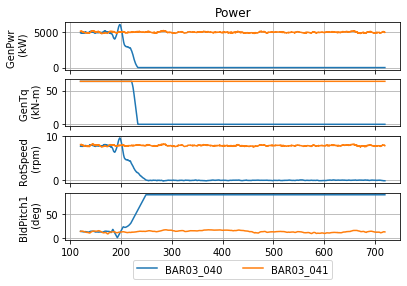

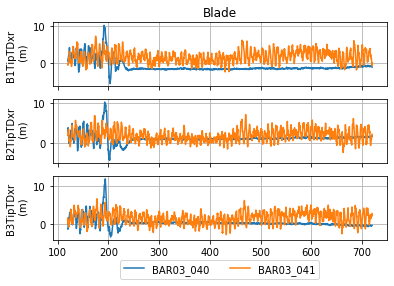

In [27]:
#  Load some time domain cases 
filenames = [outfiles[0][40], outfiles[0][41]]
fast_data = fast_io.load_FAST_out(filenames, tmin=0)
cases = {'Power': ['GenPwr', 'GenTq', 'RotSpeed', 'BldPitch1'],
        'Blade' : ['B1TipTDxr', 'B2TipTDxr', 'B3TipTDxr']}
fast_pl.plot_fast_out(cases, fast_data)
plt.show()